# State of Top 20 Languages: Project Size

This notebook analyzes project size for the hosted projects of the top 20 most spoken languages of 2023.


In this notebook,
* **projects** refer to [Wikimedia content projects](https://meta.wikimedia.org/wiki/Wikimedia_projects) that have linguistic editions: Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wikiversity, Wikivoyage, and Wiktionary; 
* **hosted projects** refer to projects that have their own domain and are hosted by the Wikimedia Foundation; and 
* **project size** refers to the number of unique mainspace pages in a project

For the year 2023, the "top 20" were determined via Ethnologue's 2023 "Ethnologue 200" list, from which the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

Citation: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.

## Packages and Functions

In [26]:
# Packages
library(tidyverse)
library(janitor)
library(kableExtra)# for html tables
library(IRdisplay) # for html tables
library(DT) # for html tables
library(here)
library(ggrepel)

In [27]:
#install.packages("remotes", repos = c(CRAN = "https://cran.rstudio.com/"))
#remotes::install_github("wikimedia/wmfdata-r")
library(wmfdata)
library(glue)

In [28]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
library(jsonlite)
library(reticulate)
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')

In [29]:
## ggplot theme: state of languages (sol) theme ---------

theme_sol <- function(){ 
      
  theme(legend.position="none", 
        axis.title=element_blank(), 
        axis.text.y=element_text(size=18),
        axis.text.x=element_blank(),
        plot.title=element_text(size=24),
        plot.subtitle=element_text(size=18),
        plot.caption=element_text(size=12)
       )  

}

In [30]:
# increase column and row maxes
options(repr.matrix.max.cols=12, repr.matrix.max.rows=1100)

## Read in data

**First, state of languages data**

In [31]:
df_import <- read_tsv("outputs/state_of_languages_with_counts_and_notes.tsv")

Rows: 1134 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (10): language_name, Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisour...
dbl  (4): n_hosted_open, n_test_closure, n_test_initial, n_all_types

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Second, page counts data**

In [32]:
## Spark query: mainspace page counts, per wiki, December 2023

##query
#pages_dec_2024 <- wmfdata$spark$run("
#SELECT 
#    wiki_db,
#    COUNT(DISTINCT(page_id)) as count
#FROM wmf_raw.mediawiki_page
#WHERE
#    snapshot = '2024-12' AND
#    page_namespace = 0 AND
#    page_is_redirect = 0
#GROUP BY
#   wiki_db
#")

In [33]:
head(pages_dec_2024)

wiki_db      count  
1 iawiki         30006
2 hrwikisource    9775
3 cswiktionary  153692
4 bswiktionary   10521
5 bmwikiquote        1
6 viwiki       1293963

In [42]:
## Filter Spark query (above) for projects of top 20 languages only. Create df.
pages_dec_2024_top_20 <- pages_dec_2024 %>%
   filter(
       startsWith(wiki_db, "enwik") | # English 
       startsWith(wiki_db, "zhwik") | # Mandarin/Chinese 
       startsWith(wiki_db, "hiwik") | # Hindi 
       startsWith(wiki_db, "eswik") | # Spanish 
       startsWith(wiki_db, "frwik") | # French 
       startsWith(wiki_db, "arwik") | # Arabic 
       startsWith(wiki_db, "ptwik") | # Portuguese 
       startsWith(wiki_db, "ruwik") | # Russian 
       startsWith(wiki_db, "urwik") | # Urdu 
       startsWith(wiki_db, "idwik") | # Indonesian 
       startsWith(wiki_db, "dewik") | # German 
       startsWith(wiki_db, "jawik") | # Japanese 
       startsWith(wiki_db, "pcmwik") | # Nigerian Pidgin 
       startsWith(wiki_db, "arzwik") | # Egyptian Arabic 
       startsWith(wiki_db, "mrwik") | # Marathi 
       startsWith(wiki_db, "tewik") | # Telugu 
       startsWith(wiki_db, "trwik") | # Turkish 
       startsWith(wiki_db, "tawik") | # Tamil 
       startsWith(wiki_db, "bnwik") | # Bengali|Bangla 
       startsWith(wiki_db, "yuewik") | # Yue/Cantonese (wiktionary is 'yuewiktionary')  
       startsWith(wiki_db, "zh_yuewik") # Yue/Cantonese (wikipedia is "zh_yuewiki")
    ) 

In [43]:
## Filter pages_dec_2024_top_20 for Wikipedias only. Create df.
wp_articles <- pages_dec_2024_top_20 %>%
    filter(endsWith(wiki_db, "wiki"))%>%
    select(wiki_db, count) %>%
    rename(wp_page_count=count) 

# Filter pages_dec_2024_top_20 for Wiktionaries only. Create df.
wt_articles <- pages_dec_2024_top_20 %>%
    filter(endsWith(wiki_db, "wiktionary"))%>%
    select(wiki_db, count) %>%
   rename(wt_page_count=count)

# Filter pages_dec_2024_top_20 for Wikisource only. Create df.
ws_articles <- pages_dec_2024_top_20 %>%
    filter(endsWith(wiki_db, "wikisource"))%>%
    select(wiki_db, count) %>%
   rename(ws_page_count=count)

**Finally, bring in bridge for project name and language code**

In [44]:
langs <- read_tsv("../03_wrangled_data/project_languages.tsv") %>%
   select(language_name, language_code)
head(langs)

Rows: 2540 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): prefix, project, language_code, language_name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


language_name language_code
1 Afar          aa           
2 Afar          aa           
3 Afar          aa           
4 Afar          aa           
5 Afar          aa           
6 Ghotuo        aaa

### Prep "df_top_20"
Dataframe for examining stats about the *top 20* languages ranked by speaker numbers.

**Source**: For the year 2023, the "top 20" were determined via Ethnologue's 2023 "Ethnologue 200" list, from which the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

**Citation**: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.


In [45]:
df <- df_import
df$Wikibooks[is.na(df$Wikibooks)] <- "(none)"
df$Wikinews[is.na(df$Wikinews)] <- "(none)"
df$Wikipedia[is.na(df$Wikipedia)] <- "(none)"
df$Wikiquote[is.na(df$Wikiquote)] <- "(none)"
df$Wikisource[is.na(df$Wikisource)] <- "(none)"
df$Wiktionary[is.na(df$Wiktionary)] <- "(none)"
df$Wikiversity[is.na(df$Wikiversity)] <- "(none)"
df$Wikivoyage[is.na(df$Wikivoyage)] <- "(none)"

In [46]:
df_top_20 <- df %>% filter(language_name=="English" | #1
                  language_name=="Chinese" | #2
                  language_name=="Hindi" | #3
                  language_name=="Spanish" | #4
                  language_name=="French" | #5
                  language_name=="Arabic" | #6
                  grepl("Bangla|Bengali", language_name) | #7
                  language_name=="Portuguese" | #8
                  language_name=="Russian" | #9
                  language_name=="Urdu" | #10
                  language_name=="Indonesian" | #11
                  language_name=="German" | #12
                  language_name=="Japanese" | #13
                  grepl("Nigerian Pidgin", language_name) | #14
                  language_name=="Egyptian Arabic" | #15
                  language_name=="Marathi" | #16
                  language_name=="Telugu" | #17
                  language_name=="Turkish" | #18
                  language_name=="Tamil" | #19
                  grepl("Yue|Cantonese", language_name) ) #20
print(nrow(df_top_20))
head(df_top_20)

[1] 20


language_name   Wikibooks Wikinews Wikipedia Wikiquote Wikisource ⋯
1 Arabic          hosted    hosted   hosted    hosted    hosted     ⋯
2 Bangla          hosted    test     hosted    hosted    hosted     ⋯
3 Cantonese       test      test     hosted    test      test       ⋯
4 Chinese         hosted    hosted   hosted    hosted    hosted     ⋯
5 Egyptian Arabic test      -        hosted    test      -          ⋯
6 English         hosted    hosted   hosted    hosted    hosted     ⋯
  Wiktionary n_hosted_open n_test_closure n_test_initial n_all_types
1 hosted     7             0              1              8          
2 hosted     6             0              2              8          
3 hosted     2             0              5              7          
4 hosted     8             0              0              8          
5 test       1             0              3              4          
6 hosted     8             0              0              8          
  notes                                     
1 7 hosted projects, 1 initial test project 
2 6 hosted projects, 2 initial test projects
3 2 hosted projects, 5 initial test projects
4 8 hosted projects                         
5 1 hosted project, 3 initial test projects 
6 8 hosted projects

In [47]:
# Wikipedia: add the language codes and make a wiki_db+wp column, for matching with product data
df_top_20 <- df_top_20 %>%
   left_join(., langs, by="language_name") %>%
   distinct(.)
df_top_20$wiki_db_wp = paste(df_top_20$language_code, "wiki", sep="")

        # hand correct for Cantonese/Yue
        df_top_20$wiki_db_wp[df_top_20$language_name=="Cantonese"] <- "zh_yuewiki"

# Wiktionary: make a wiki_db_wt column, for matching with product data
df_top_20$wiki_db_wt = paste(df_top_20$language_code, "wiktionary", sep="")

# Wikisource: make a wiki_db_ws column, for matching with product data
df_top_20$wiki_db_ws = paste(df_top_20$language_code, "wikisource", sep="")

In [48]:
# add rounded speaker numbers
df_top_20$speakers <- NA
df_top_20$speakers[df_top_20$language_name=="English"]           <- 1500000000 # 1
df_top_20$speakers[df_top_20$language_name=="Chinese"]           <- 1100000000 # 2, Ethnologue called "Mandarin Chinese"
df_top_20$speakers[df_top_20$language_name=="Hindi"]             <-  609500000 # 3
df_top_20$speakers[df_top_20$language_name=="Spanish"]           <-  559100000 # 4
df_top_20$speakers[df_top_20$language_name=="French"]            <-  309800000 # 5
df_top_20$speakers[df_top_20$language_name=="Arabic"]            <-  274000000 # 6, Ethnologue called "Standard Arabic"
df_top_20$speakers[df_top_20$language_name=="Bangla"]            <-  272800000 # 7
df_top_20$speakers[df_top_20$language_name=="Portuguese"]        <-  263600000 # 8
df_top_20$speakers[df_top_20$language_name=="Russian"]           <-  255000000 # 9
df_top_20$speakers[df_top_20$language_name=="Urdu"]              <-  231700000 # 10
df_top_20$speakers[df_top_20$language_name=="Indonesian"]        <-  199100000 # 11
df_top_20$speakers[df_top_20$language_name=="German"]            <-  133200000 # 12, Ethnologue called "Standard German"
df_top_20$speakers[df_top_20$language_name=="Japanese"]          <-  123400000 # 13
df_top_20$speakers[df_top_20$language_name=="Nigerian Pidgin"]   <-  120700000 # 14
df_top_20$speakers[df_top_20$language_name=="Egyptian Arabic"]   <-  102400000 # 15, Ethnologue called "Egyptian Spoken Arabic"
df_top_20$speakers[df_top_20$language_name=="Marathi"]           <-   99200000 # 16
df_top_20$speakers[df_top_20$language_name=="Telugu"]            <-   96000000 # 17
df_top_20$speakers[df_top_20$language_name=="Turkish"]           <-   90000000 # 18
df_top_20$speakers[df_top_20$language_name=="Tamil"]             <-   86600000 # 19
df_top_20$speakers[df_top_20$language_name=="Cantonese"]         <-   86600000 # 20 Ethnologue called "Yue Chinese"

# Speaker numbers source: For the year 2023, speaker numbers for the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ 
# (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

# Citation: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. 
# Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.

In [49]:
# join with wikipedia article numbers
df_top_20 <- df_top_20 %>%
   left_join(., wp_articles, by=c("wiki_db_wp"="wiki_db"))

# join with wiktionary page numbers
df_top_20 <- df_top_20 %>%
   left_join(., wt_articles, by=c("wiki_db_wt"="wiki_db"))

# join with wikisource page numbers
df_top_20 <- df_top_20 %>%
   left_join(., ws_articles, by=c("wiki_db_ws"="wiki_db"))

df_top_20

language_name   Wikibooks Wikinews      Wikipedia Wikiquote Wikisource ⋯
1  Arabic          hosted    hosted        hosted    hosted    hosted     ⋯
2  Bangla          hosted    test          hosted    hosted    hosted     ⋯
3  Cantonese       test      test          hosted    test      test       ⋯
4  Chinese         hosted    hosted        hosted    hosted    hosted     ⋯
5  Egyptian Arabic test      -             hosted    test      -          ⋯
6  English         hosted    hosted        hosted    hosted    hosted     ⋯
7  French          hosted    hosted        hosted    hosted    hosted     ⋯
8  German          hosted    hosted        hosted    hosted    hosted     ⋯
9  Hindi           hosted    test          hosted    hosted    hosted     ⋯
10 Indonesian      hosted    test          hosted    hosted    hosted     ⋯
11 Japanese        hosted    hosted        hosted    hosted    hosted     ⋯
12 Marathi         hosted    test          hosted    hosted    hosted     ⋯
13 Nigerian Pidgin -         -             hosted    -         -          ⋯
14 Portuguese      hosted    hosted        hosted    hosted    hosted     ⋯
15 Russian         hosted    hosted        hosted    hosted    hosted     ⋯
16 Spanish         hosted    hosted        hosted    hosted    hosted     ⋯
17 Tamil           hosted    hosted        hosted    hosted    hosted     ⋯
18 Telugu          hosted    test          hosted    hosted    hosted     ⋯
19 Turkish         hosted    test (closed) hosted    hosted    hosted     ⋯
20 Urdu            hosted    test          hosted    hosted    test       ⋯
   wiki_db_wt    wiki_db_ws    speakers  wp_page_count wt_page_count
1  arwiktionary  arwikisource  2.740e+08 1248906         72338      
2  bnwiktionary  bnwikisource  2.728e+08  161725        109010      
3  yuewiktionary yuewikisource 8.660e+07  143189          7966      
4  zhwiktionary  zhwikisource  1.100e+09 1457048       2267815      
5  arzwiktionary arzwikisource 1.024e+08 1626048            NA      
6  enwiktionary  enwikisource  1.500e+09 6933133       8280019      
7  frwiktionary  frwikisource  3.098e+08 2656162       6412702      
8  dewiktionary  dewikisource  1.332e+08 2973542       1151611      
9  hiwiktionary  hiwikisource  6.095e+08  167253        195415      
10 idwiktionary  idwikisource  1.991e+08  711690        167862      
11 jawiktionary  jawikisource  1.234e+08 1442764        415700      
12 mrwiktionary  mrwikisource  9.920e+07   99638          3579      
13 pcmwiktionary pcmwikisource 1.207e+08    1537            NA      
14 ptwiktionary  ptwikisource  2.636e+08 1141115        493919      
15 ruwiktionary  ruwikisource  2.550e+08 2017140       1384544      
16 eswiktionary  eswikisource  5.591e+08 1933499        934592      
17 tawiktionary  tawikisource  8.660e+07  172116        408429      
18 tewiktionary  tewikisource  9.600e+07  102409        108890      
19 trwiktionary  trwikisource  9.000e+07  625887        390970      
20 urwiktionary  urwikisource  2.317e+08  218829         30138      
   ws_page_count
1   83176       
2   17680       
3      NA       
4  408004       
5      NA       
6  636623       
7  427751       
8  261616       
9    4545       
10   4410       
11  16140       
12   3294       
13     NA       
14  33253       
15 591137       
16  57029       
17  19797       
18  17989       
19   9524       
20     NA

## **Top 20 Languages: Wikipedia Size**

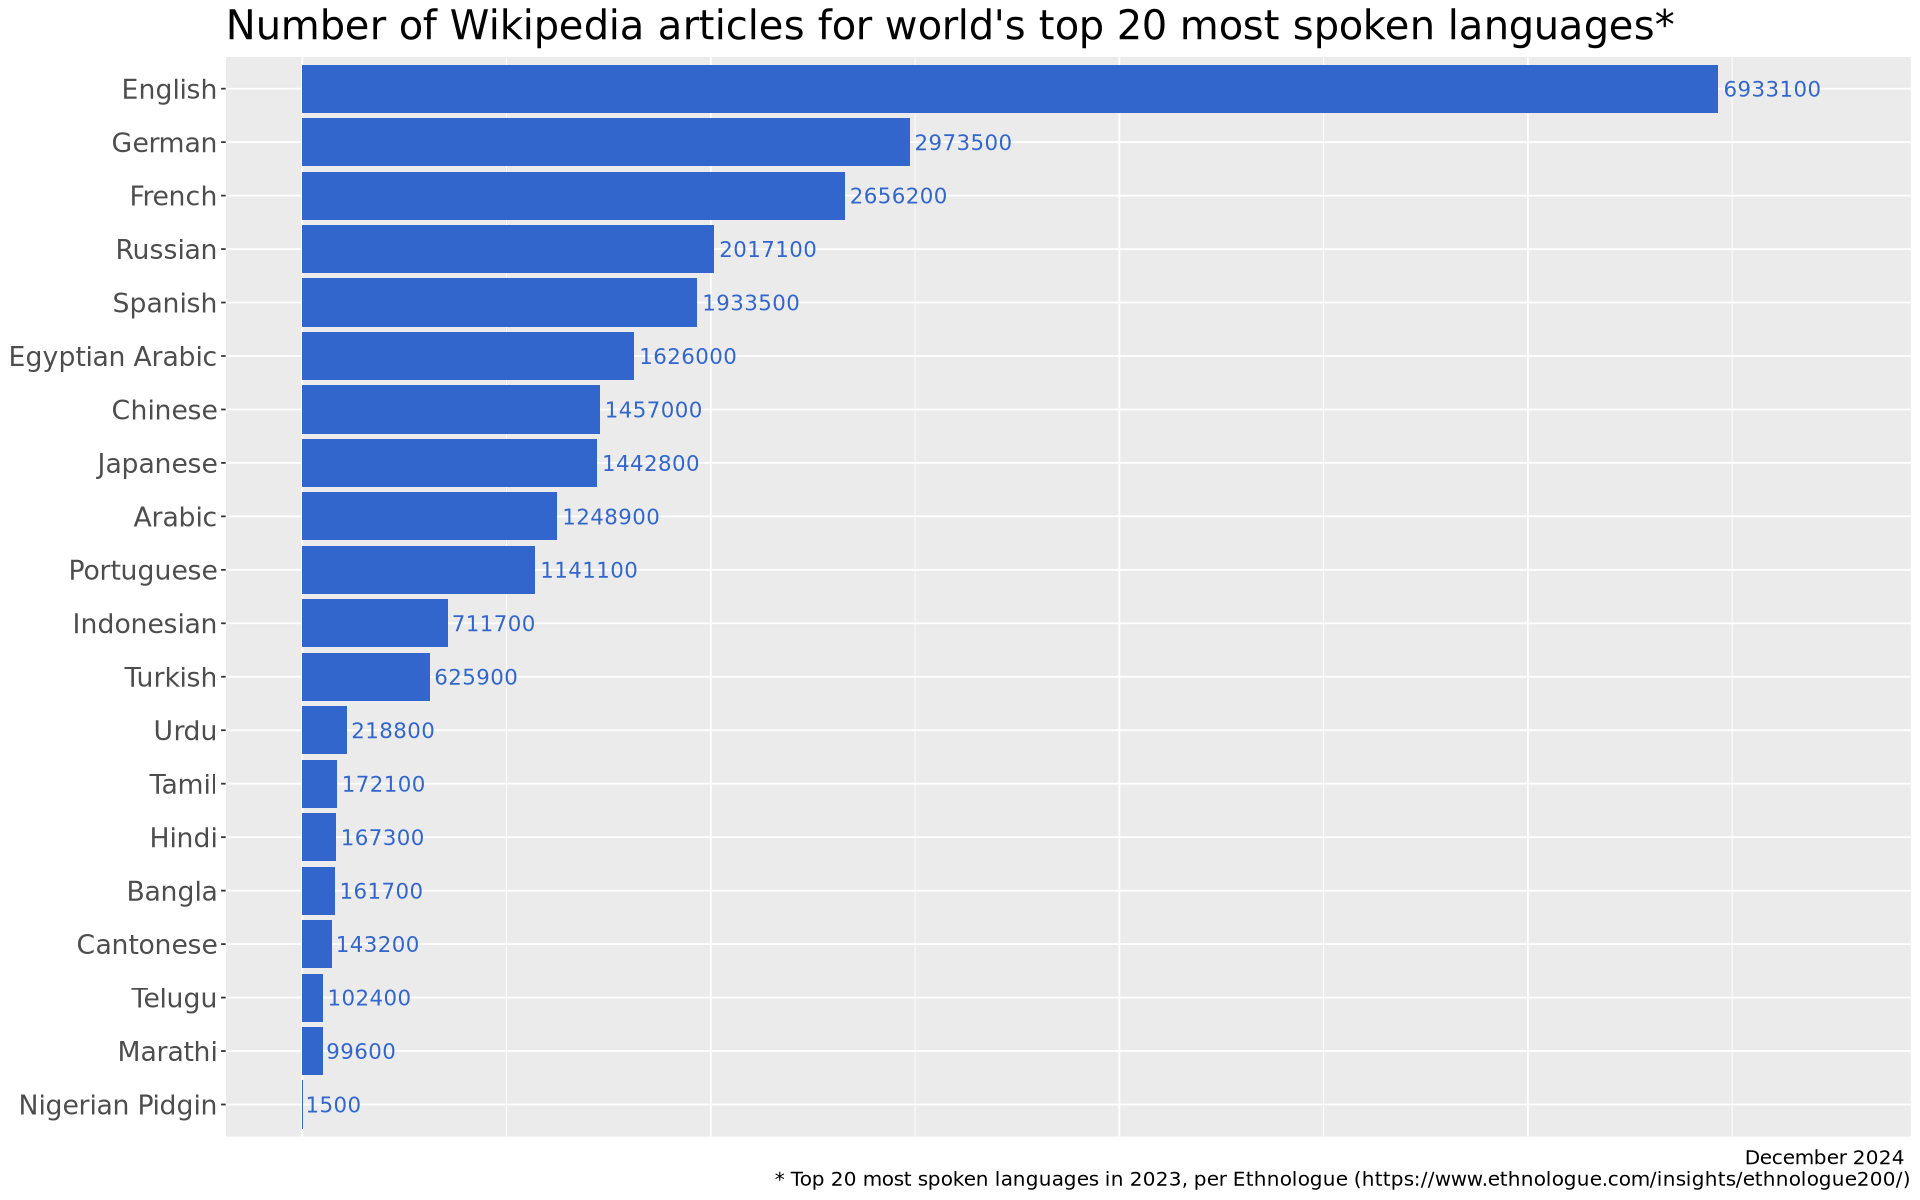

In [53]:
# Plot: Wikipedia articles per language
options(repr.plot.width=16, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=reorder(language_name, wp_page_count), y=wp_page_count)) +
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  geom_text(aes(label = round(wp_page_count,-2)), hjust = -0.05, color="#3366CC", size=4.5) +
  theme_sol() +
  coord_flip() + 
  labs(title = "Number of Wikipedia articles for world's top 20 most spoken languages*",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  theme(axis.text.y = element_text(size=16), axis.ticks.x = element_blank() ) +
  ylim(c(0,7500000))

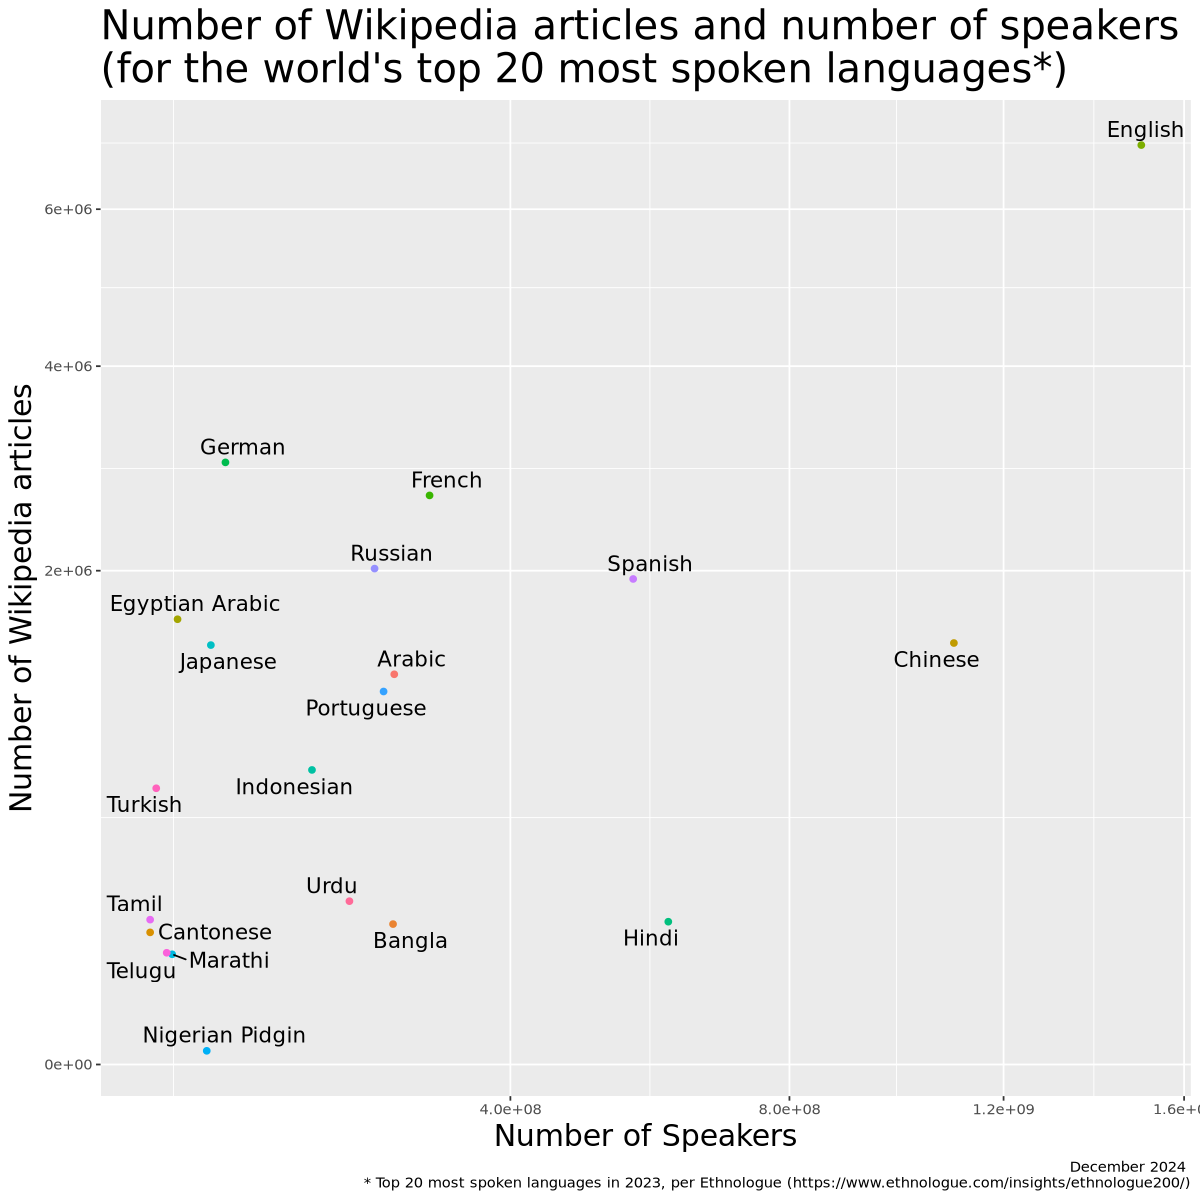

In [54]:
# Plot: Wikipiedia articles x speaker numbers
# Axis transformation: squareroot
options(repr.plot.width=10, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=speakers, y=wp_page_count, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24)) +
  labs(title = "Number of Wikipedia articles and number of speakers \n(for the world's top 20 most spoken languages*)",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Number of Speakers") + ylab("Number of Wikipedia articles") +
  scale_x_continuous(trans='sqrt') +
  scale_y_continuous(trans='sqrt')

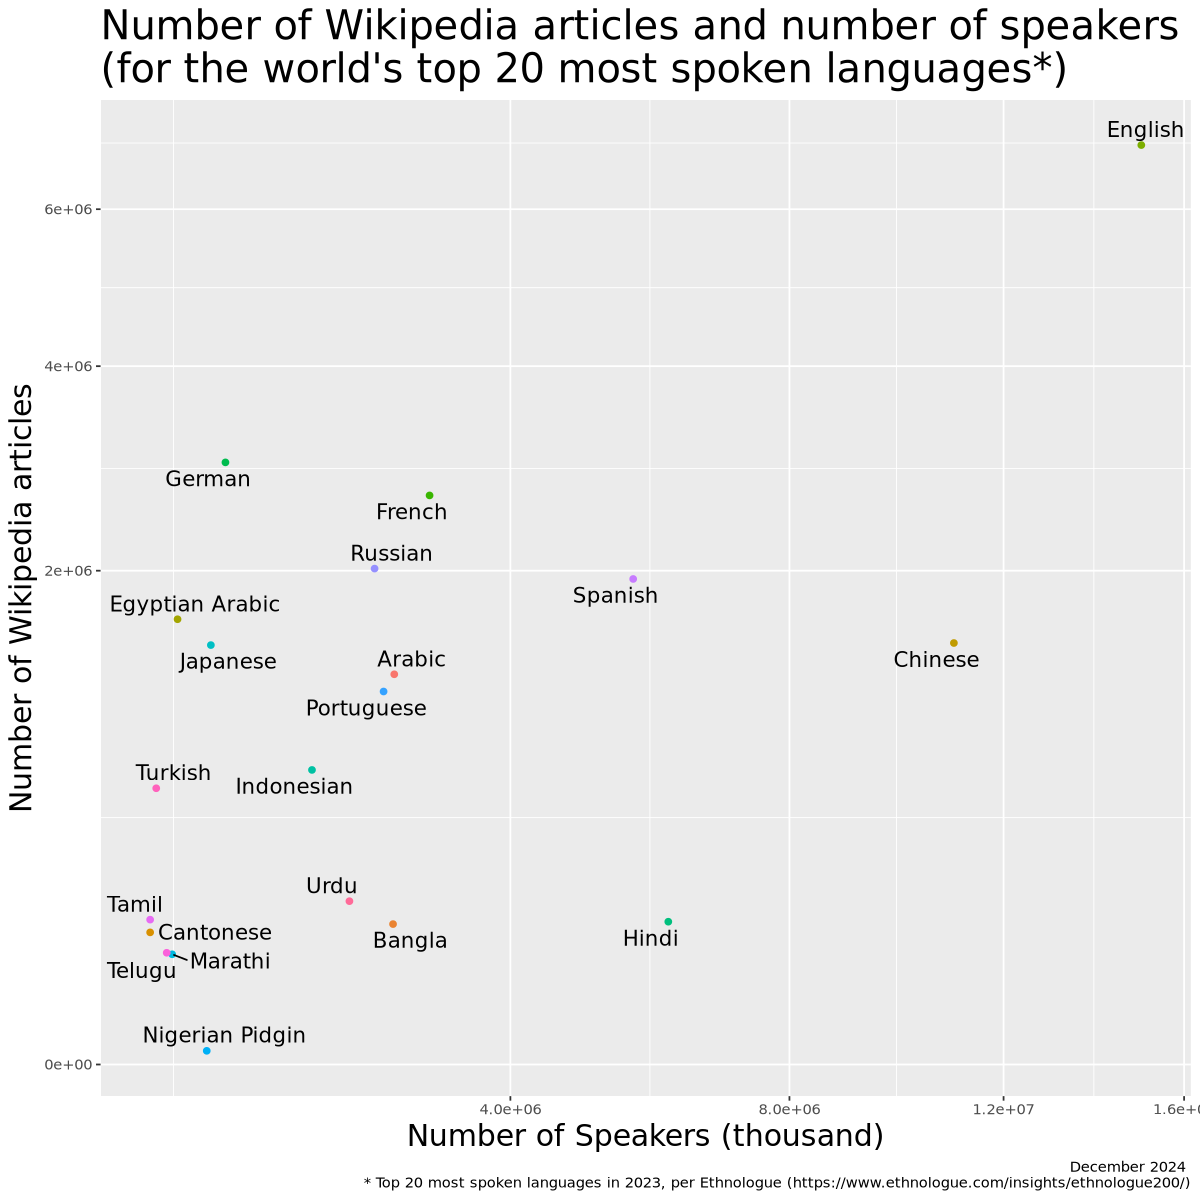

In [62]:
# Plot: Ajusted Wikipiedia articles x speaker numbers
# Axis transformation: make the whole plot into a true square, adjusting speaker counts (x1000)
options(repr.plot.width=10, repr.plot.height=10)
df_top_20 %>%
  mutate(speakers_thousand = speakers / 100) %>%
  ggplot(aes(x=speakers_thousand, y=wp_page_count, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24)) +
  labs(title = "Number of Wikipedia articles and number of speakers \n(for the world's top 20 most spoken languages*)",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Number of Speakers (thousand)") + ylab("Number of Wikipedia articles") +
  scale_x_continuous(trans='sqrt') +
  scale_y_continuous(trans='sqrt') 

In [63]:
# Case example: German and Indonesian
case <- df_top_20 %>%
 filter(language_name=="German" | language_name=="Indonesian") %>%
 select(language_name, wp_page_count, speakers)
case

     GS = case$speakers[case$language_name=="German"]
     IS = case$speakers[case$language_name=="Indonesian"]

     GW = case$wp_page_count[case$language_name=="German"]
     IW = case$wp_page_count[case$language_name=="Indonesian"]

    # speaker difference (%)
     round ( (IS-GS) / ((IS+GS)/2) * 100 , 1)

    # wp difference (%)
     round ( (IW-GW) / ((IW+GW)/2) * 100 , 1)

    # german speaker pop as a fraction of indonesian speaker pop
    GS/IS

    # german wp size as "__ x indonesian wp size"
    GW/IW

    # how many German articles per German speaker
    ag = GW/GS
    ag

    # how many German articles per German speaker
    ai = IW/IS
    ai

    # how many German articles per each Indonesian 
    ag/ai

language_name wp_page_count speakers 
1 German        2973542       133200000
2 Indonesian     711690       199100000

[1] 39.7

[1] -122.8

[1] 0.6690105

[1] 4.178142

[1] 0.02232389

[1] 0.003574535

[1] 6.245256

Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


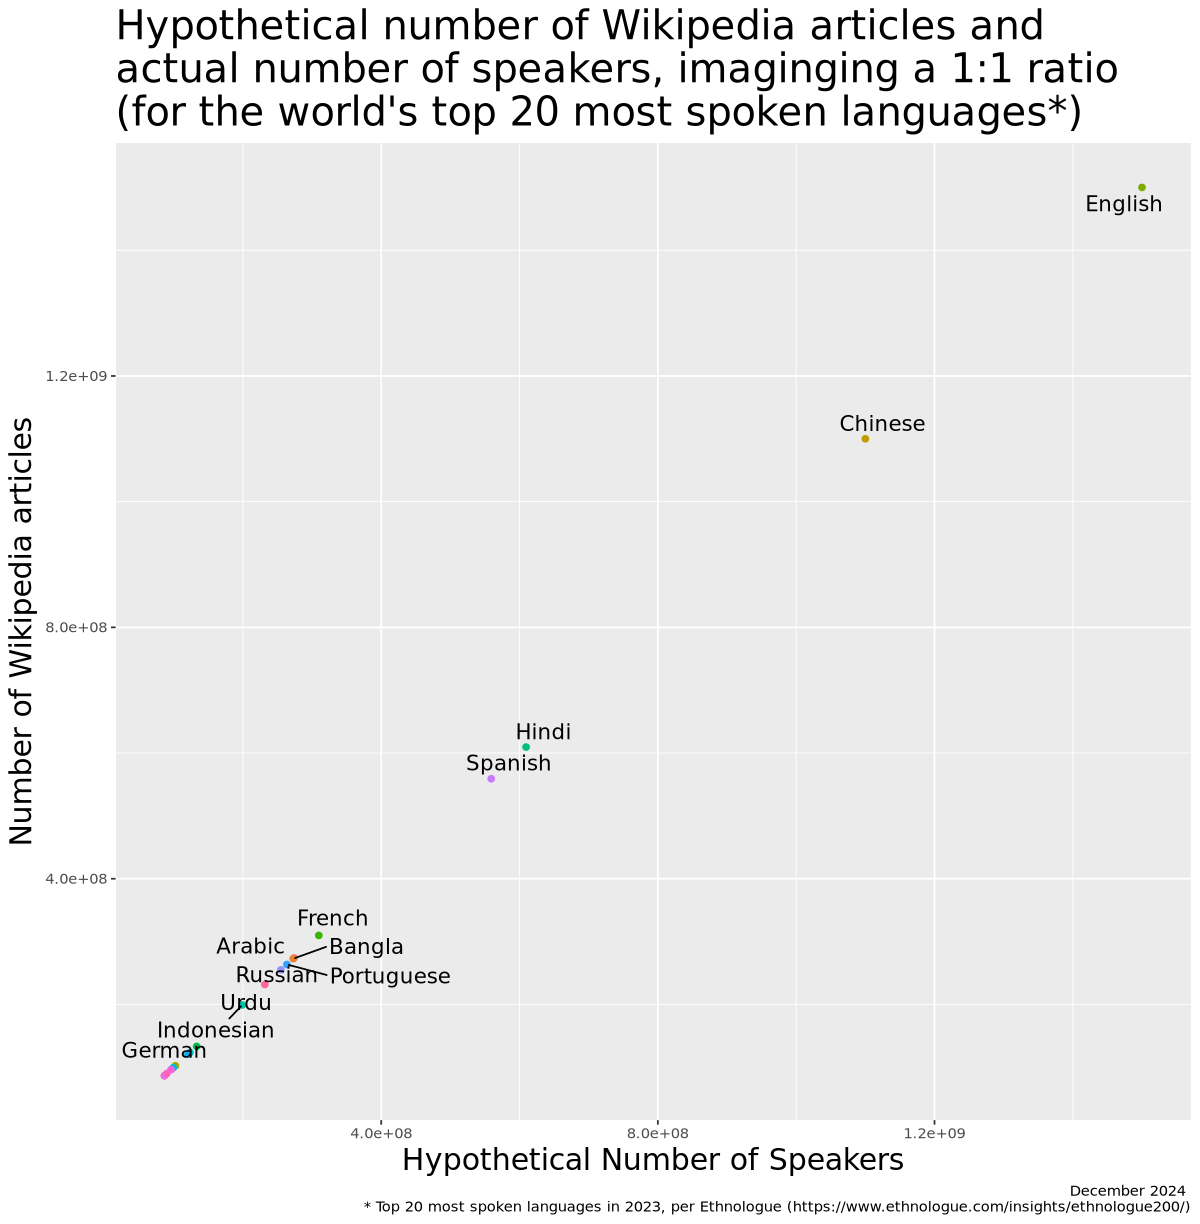

In [65]:
# Plot: Hypothetical Wikipiedia articles x actual speaker numbers
# Imagining A 1:1 ratio .......
options(repr.plot.width=10, repr.plot.height=10.2)
df_top_20 %>%
  mutate(wp_page_count_hypo = speakers) %>%
  ggplot(aes(x=speakers, y=wp_page_count_hypo, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24)) +
   labs(title = "Hypothetical number of Wikipedia articles and \nactual number of speakers, imaginging a 1:1 ratio \n(for the world's top 20 most spoken languages*) ",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Hypothetical Number of Speakers") + ylab("Number of Wikipedia articles") 

## **Top 20 Languages: Wiktionary Size**

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text()`).”


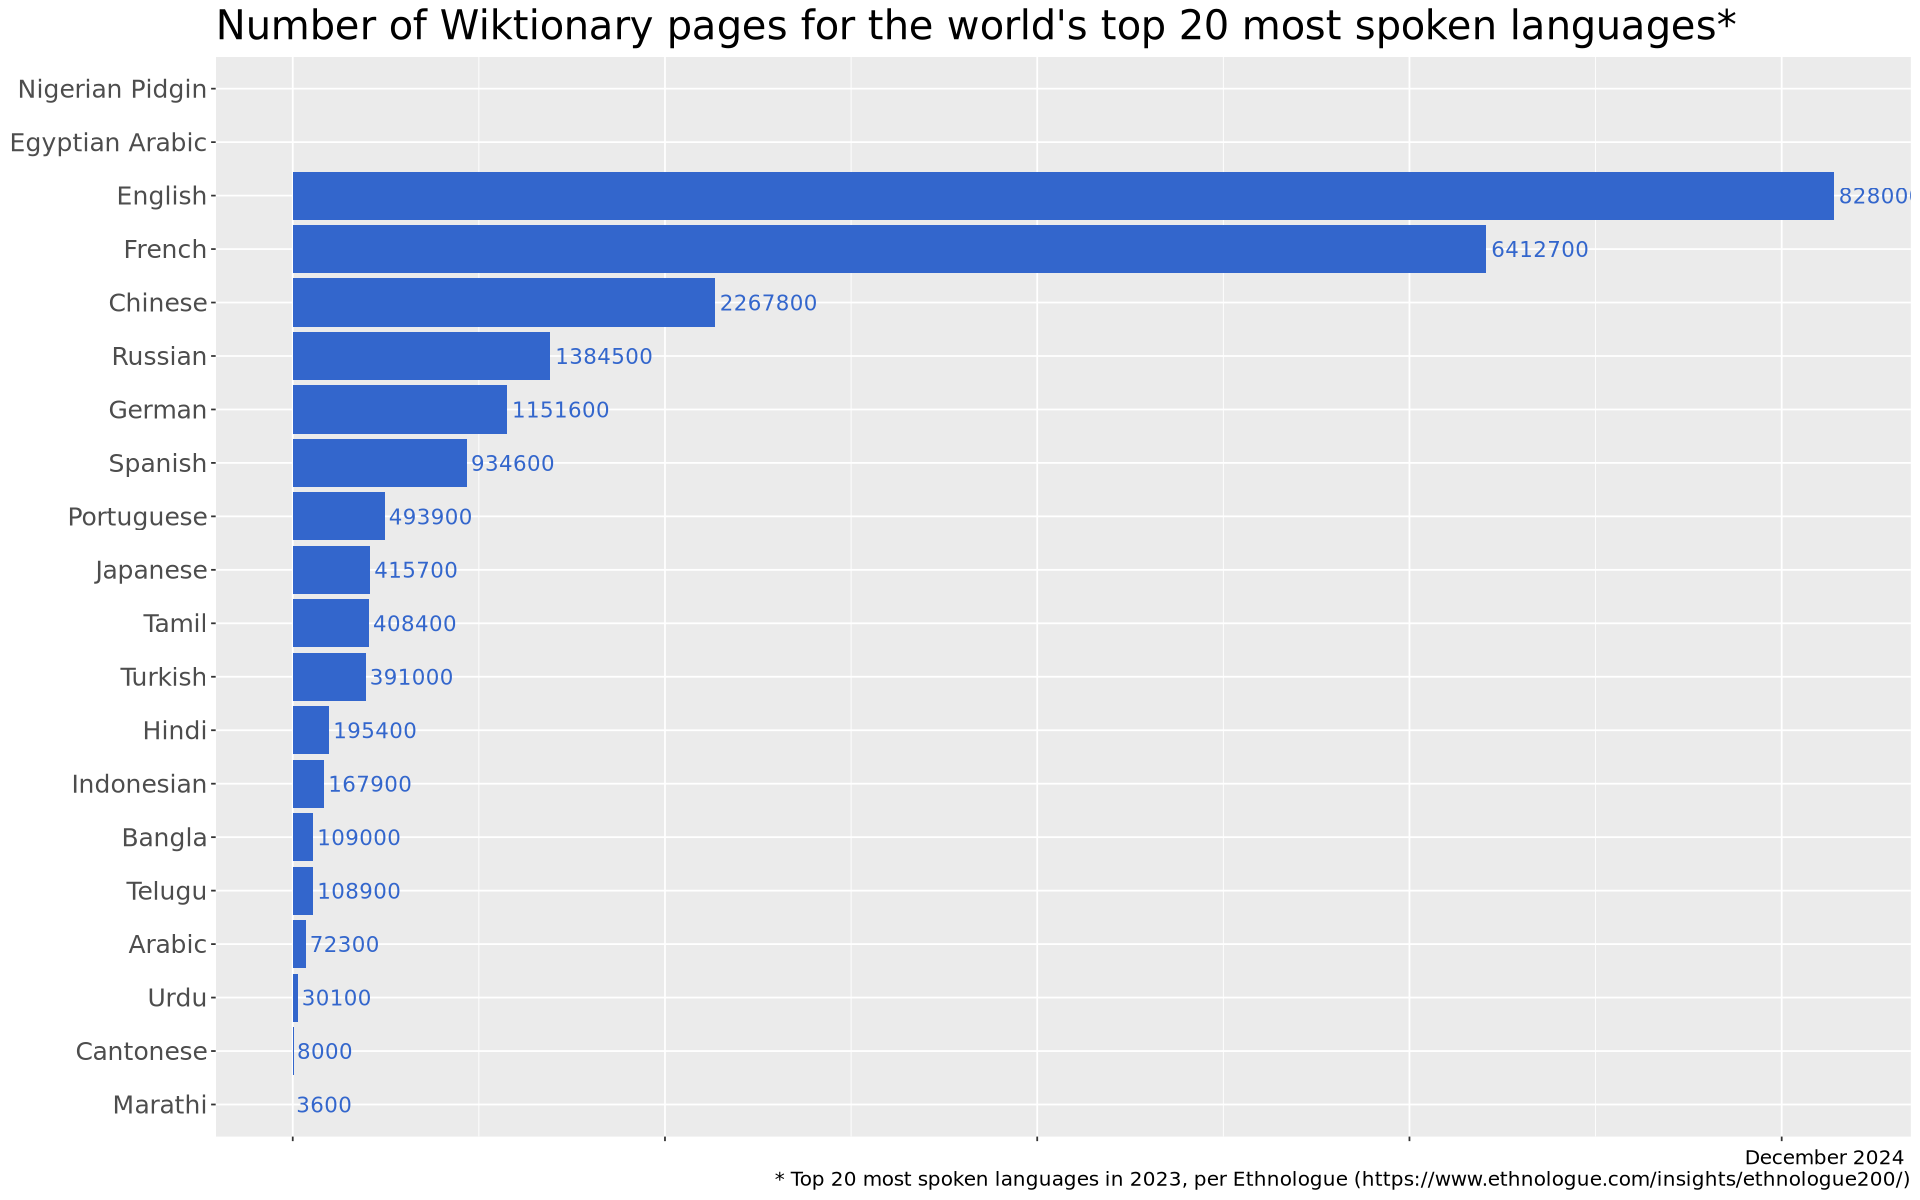

In [66]:
# Plot: Wiktionary pages per language
options(repr.plot.width=16, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=reorder(language_name, wt_page_count), y=wt_page_count)) +
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  geom_text(aes(label = round(wt_page_count,-2)), hjust = -0.05, color="#3366CC", size=4.5) +
  theme_sol() +
  coord_flip() + 
  labs(title = "Number of Wiktionary pages for the world's top 20 most spoken languages*",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  theme(axis.text.y = element_text(size=15) )

# Note: warning message and missing bars indicate no Wiktionary for the language(s)

## **Top 20 Languages: Wikisource Size**

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text()`).”


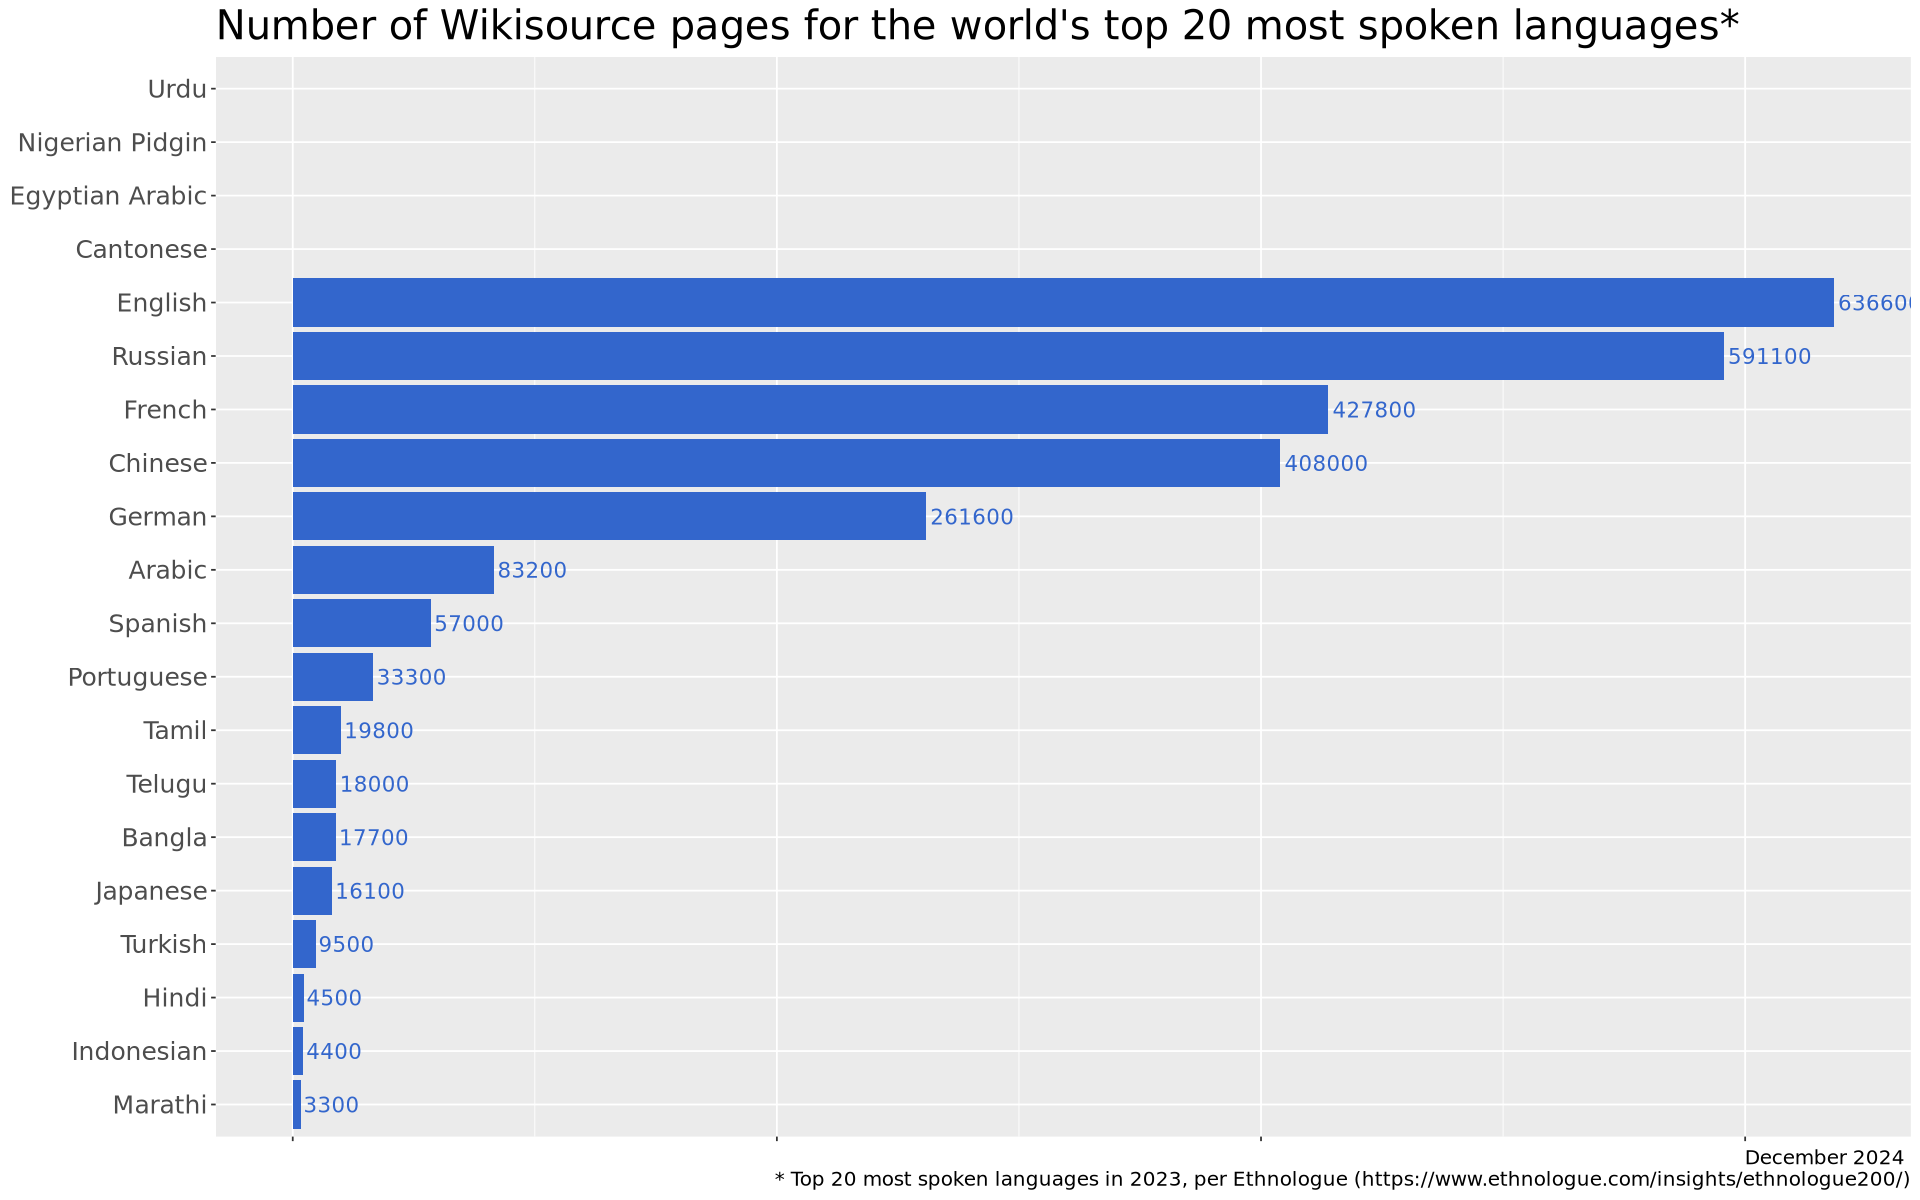

In [67]:
# Plot: Wikisource pages per language
options(repr.plot.width=16, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=reorder(language_name, ws_page_count), y=ws_page_count)) +
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  geom_text(aes(label = round(ws_page_count,-2)), hjust = -0.05, color="#3366CC", size=4.5) +
  theme_sol() +
  coord_flip() + 
  labs(title = "Number of Wikisource pages for the world's top 20 most spoken languages*",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  theme(axis.text.y = element_text(size=15) ) 

# Note: warning message and missing bars indicate no Wikisource for the language(s)

Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


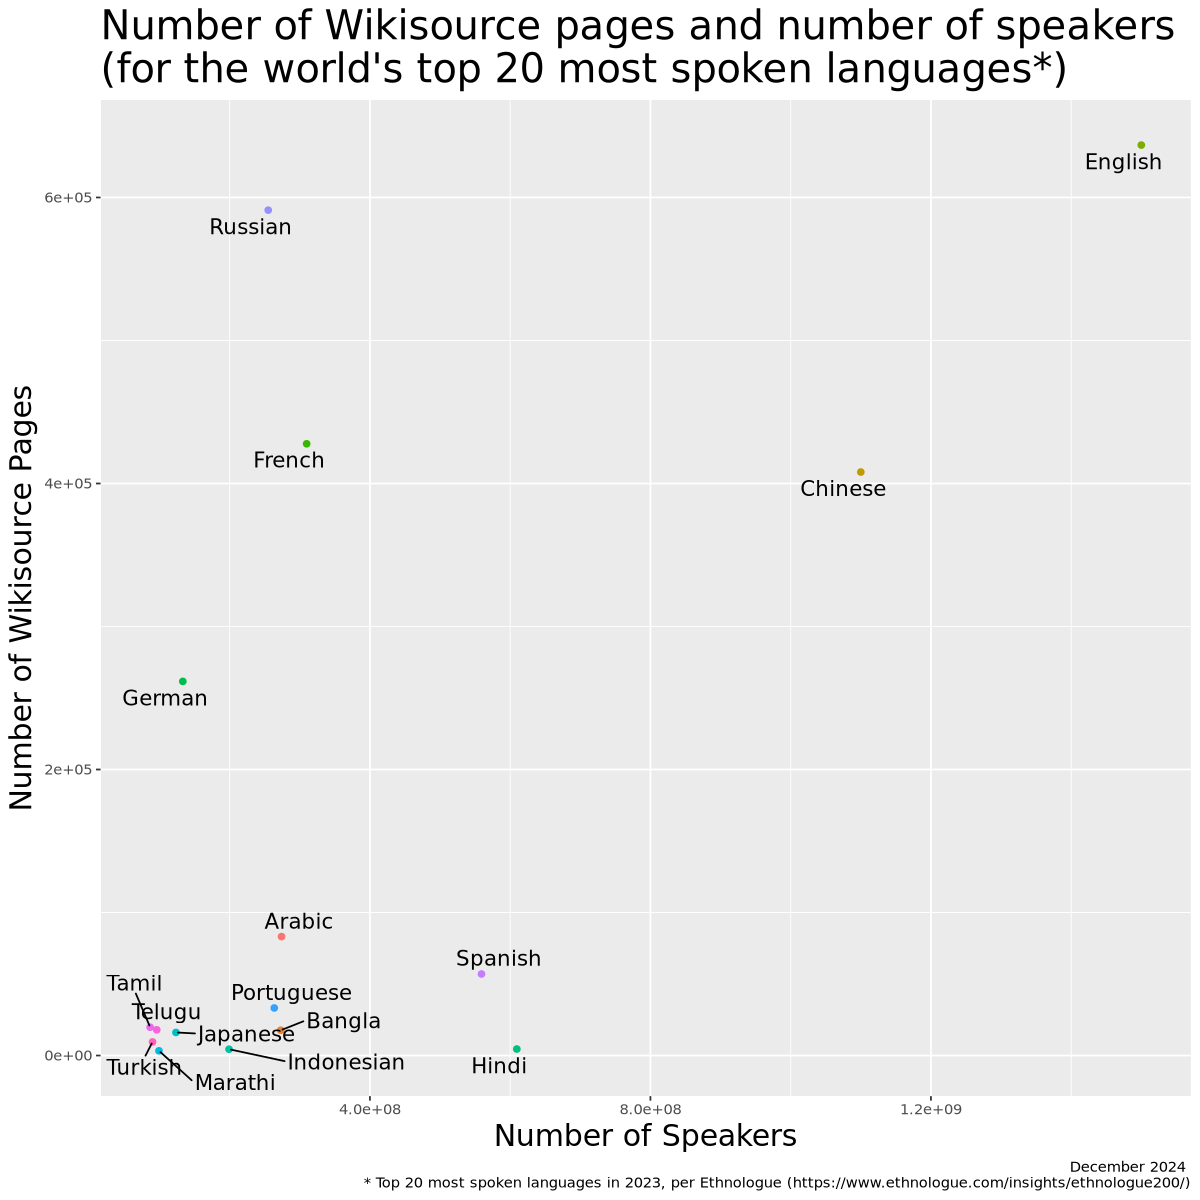

In [68]:
# Plot: Ws articles x speaker numbers
# Axis transformation: squareroot
options(repr.plot.width=10, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=speakers, y=ws_page_count, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24)) +
  labs(title = "Number of Wikisource pages and number of speakers \n(for the world's top 20 most spoken languages*)",
       caption = "December 2024 \n* Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Number of Speakers") + ylab("Number of Wikisource Pages")